# Visualization Variant Painting Images and Cells

In [1]:
import os
import glob
import polars as pl
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from tqdm import tqdm
import re
import sys
import subprocess
from skimage.transform import resize

sys.path.append("../..")
from img_utils import *
from display_img import *
from display_cells import *

## 1. Loading meta data and variant classification

In [2]:
OUT_IMG_DIR = f"../../2.snakemake_pipeline/outputs/visualize_imgs"
OUT_CELL_DIR = f"../../2.snakemake_pipeline/outputs/visualize_cells"

### 1.1 Read in the meta data

In [3]:
# allele_meta_df, img_well_qc_sum_df = pl.DataFrame(), pl.DataFrame()
# allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

# for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
#     for batch_id in bio_rep_batches:
#         allele_meta_df_batch = pl.DataFrame()
#         platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
#         for platemap in platemaps:
#             platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
#             allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
#                                         platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
#                                         how="diagonal_relaxed").sort("plate_map_name")
#             allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
#             # display(allele_meta_df.head())
#         allele_meta_df = pl.concat([
#             allele_meta_df,
#             allele_meta_df_batch
#         ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
#     allele_meta_df_dict[bio_rep] = allele_meta_df_batch

#     img_well_qc_sum = pl.read_csv(f"{IMGS_QC_METRICS_DIR}/{bio_rep}/plate-well-level_img_qc_sum.csv")
#     img_well_qc_sum = img_well_qc_sum.with_columns(
#         pl.col("channel").replace("DAPI", "DNA").alias("channel")
#     )
#     img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
#     img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
#         pl.col("is_bg").max().alias("is_bg"),
#         pl.col("s2n_ratio").mean().alias("s2n_ratio")
#     ).with_columns(pl.lit("Morph").alias("channel"))
#     img_well_qc_sum = pl.concat([
#         img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
#         img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
#     ], how="vertical_relaxed")
#     img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [4]:
allele_meta_df = pl.read_csv(IMG_METADATA_FILE, infer_schema_length=10000)
img_well_qc_sum_df = pl.read_csv(IMG_QC_SUM_DF_FILE, infer_schema_length=10000)

with open(IMG_METADATA_DICT_FILE, "rb") as f:
    allele_meta_df_dict = pickle.load(f)

with open(IMG_QC_SUM_DICT_FILE, "rb") as f:
    img_well_qc_sum_dict = pickle.load(f)

# auroc_df = pl.read_csv(f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_all.csv")
# auroc_df.unique("gene_allele")

auroc_df = pl.read_csv(f"../outputs/2.classification_results/imaging_analyses_classification_summary_all.csv", 
                       infer_schema_length=100000, separator=",")
auroc_df.unique("gene_allele")

## pillar results
# auroc_df = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_Pillar_VarChAMP/2_individual_assay_analyses/imaging/3_outputs/pillar_img_overlapped_gene_variants.csv", 
#                        infer_schema_length=100000, separator=",").with_columns(
#                            pl.lit("2025_01_Batch_13-14").alias("Metadata_Bio_Batch")
#                        )
# auroc_df.unique("gene_allele")

shape: (1_370, 33)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ symbol  ┆ gene_allel ┆ Metadata_ ┆ Altered_9 ┆ … ┆ AUROC_Bio ┆ AUROC_Bio ┆ AUROC_Bio ┆ AUROC_Bio │
│ ---     ┆ e          ┆ Bio_Batch ┆ 5th_perc_ ┆   ┆ Rep2_Mito ┆ Rep2_DNA  ┆ Rep2_GFP  ┆ Rep2_GFP_ │
│ str     ┆ ---        ┆ ---       ┆ both_batc ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ADJ       │
│         ┆ str        ┆ str       ┆ hes…      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---       │
│         ┆            ┆           ┆ ---       ┆   ┆           ┆           ┆           ┆ f64       │
│         ┆            ┆           ┆ bool      ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ SFTPC   ┆ SFTPC_Glu6 ┆ 2024_01_B ┆ false     ┆ … ┆ 0.841186  ┆ 0.584993  ┆ 0.704628  ┆ 0.62898   │
│         ┆ 6Lys       ┆ atch_7-8  ┆           ┆   ┆           ┆           ┆           ┆           │
│ KCNK18  ┆ KCNK18_Arg ┆ 2025_06_B ┆ false     ┆ … ┆ 0.679332  ┆ 0.550442  ┆ 0.765155  ┆ 0.714766  │
│         ┆ 10Gly      ┆ atch_18-1 ┆           ┆   ┆           ┆           ┆           ┆           │
│         ┆            ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆           │
│ BRAF    ┆ BRAF_Asp56 ┆ 2025_01_B ┆ false     ┆ … ┆ 0.674352  ┆ 0.50095   ┆ 0.646541  ┆ 0.580531  │
│         ┆ 5Glu       ┆ atch_13-1 ┆           ┆   ┆           ┆           ┆           ┆           │
│         ┆            ┆ 4         ┆           ┆   ┆           ┆           ┆           ┆           │
│ FARS2   ┆ FARS2_Gly3 ┆ 2025_01_B ┆ false     ┆ … ┆ 0.73982   ┆ 0.452465  ┆ 0.718513  ┆ 0.701883  │
│         ┆ Val        ┆ atch_13-1 ┆           ┆   ┆           ┆           ┆           ┆           │
│         ┆            ┆ 4         ┆           ┆   ┆           ┆           ┆           ┆           │
│ BRIP1   ┆ BRIP1_Thr2 ┆ 2025_01_B ┆ true      ┆ … ┆ 0.770114  ┆ 0.701001  ┆ 0.977711  ┆ 0.978929  │
│         ┆ 66Lys      ┆ atch_13-1 ┆           ┆   ┆           ┆           ┆           ┆           │
│         ┆            ┆ 4         ┆           ┆   ┆           ┆           ┆           ┆           │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ GBA     ┆ GBA_ALA59T ┆ 2025_06_B ┆ false     ┆ … ┆ 0.896811  ┆ 0.763688  ┆ 0.926813  ┆ 0.922633  │
│         ┆ HR         ┆ atch_18-1 ┆           ┆   ┆           ┆           ┆           ┆           │
│         ┆            ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆           │
│ MVK     ┆ MVK_Val250 ┆ 2024_01_B ┆ false     ┆ … ┆ 0.732337  ┆ 0.762226  ┆ 0.665763  ┆ 0.618115  │
│         ┆ Ile        ┆ atch_7-8  ┆           ┆   ┆           ┆           ┆           ┆           │
│ PPP2R2B ┆ PPP2R2B_Il ┆ 2025_06_B ┆ false     ┆ … ┆ 0.911814  ┆ 0.701736  ┆ 0.984289  ┆ 0.970847  │
│         ┆ e116Met    ┆ atch_18-1 ┆           ┆   ┆           ┆           ┆           ┆           │
│         ┆            ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆           │
│ GBA     ┆ GBA_Val211 ┆ 2025_06_B ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│         ┆ Ile        ┆ atch_18-1 ┆           ┆   ┆           ┆           ┆           ┆           │
│         ┆            ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆           │
│ CCM2    ┆ CCM2_Glu51 ┆ 2025_01_B ┆ false     ┆ … ┆ 0.743529  ┆ 0.757696  ┆ 0.920557  ┆ 0.847129  │
│         ┆ Ala        ┆ atch_13-1 ┆           ┆   ┆           ┆           ┆           ┆           │
│         ┆            ┆ 4         ┆           ┆   ┆           ┆           ┆           ┆           │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

## 2. Plot Variant Painting Well Images

In [ ]:
# def get_allele_batch(allele, score_df=auroc_df):
#     return score_df.filter(pl.col("gene_allele")==allele)["Metadata_Bio_Batch"].to_list()[0]


def save_allele_imgs(variant, feat, auroc_df=auroc_df, display=False, save_img=False):
    bio_rep = get_allele_batch(variant)
    auroc_df_batch = auroc_df.with_columns(
        pl.col(f"AUROC_Mean_{feat}").alias("AUROC_Mean"),
        pl.col(f"gene_allele").alias("allele_0")
    )
    ref_allele = variant.split("_")[0]
    ref_wells = allele_meta_df_dict[bio_rep].filter(pl.col("gene_allele")==ref_allele)["imaging_well"].to_list()
    var_wells = allele_meta_df_dict[bio_rep].filter(pl.col("gene_allele")==variant)["imaging_well"].to_list()
    target_file = [f for f in os.listdir(f"{OUT_IMG_DIR}/{bio_rep}") if f.startswith(f"{variant}_{feat}")]
    if target_file:
        print(target_file, "exists.")
        output_dir = ""
        if not display:
            return None

    if save_img:
        output_dir = f"{OUT_IMG_DIR}/{bio_rep}"
        print(f"Img output at {output_dir}")
    else:
        output_dir = ""

    if bio_rep != "2024_12_Batch_11-12":
        if len(ref_wells)==1 and len(var_wells)==1:
            plot_allele(allele_meta_df_dict[bio_rep],
                            variant=variant, sel_channel=feat, 
                            auroc_df=auroc_df_batch, 
                            plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                            site="05", max_intensity=0.99, 
                            display=display,
                            imgs_dir=TIFF_IMGS_DIR, 
                            output_dir=output_dir)
        else:
            for ref_well in ref_wells:
                for var_well in var_wells:
                    plot_allele(allele_meta_df_dict[bio_rep],
                                variant=variant, sel_channel=feat, 
                                auroc_df=auroc_df_batch, 
                                plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                                site="05", max_intensity=0.99, 
                                display=display,
                                ref_well=[ref_well], 
                                var_well=[var_well],
                                imgs_dir=TIFF_IMGS_DIR, 
                                output_dir=output_dir)
    else:
        if len(ref_wells)==4 and len(var_wells)==4:
            plot_allele_single_plate(allele_meta_df_dict[bio_rep], ##.filter(pl.col("plate_map_name").str.contains("B13")
                                     variant=variant, sel_channel=feat, 
                                     auroc_df=auroc_df_batch, 
                                     plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                                     site="05", max_intensity=0.99, 
                                     display=display,
                                     imgs_dir=TIFF_IMGS_DIR, 
                                     output_dir=output_dir)
        else:
            ref_wells_idx = len(ref_wells) // 4
            var_wells_idx = len(var_wells) // 4
            for rw_idx in range(ref_wells_idx):
                for vw_idx in range(var_wells_idx):
                    plot_allele_single_plate(allele_meta_df_dict[bio_rep], ##.filter(pl.col("plate_map_name").str.contains("B13")
                                     variant=variant, sel_channel=feat, 
                                     auroc_df=auroc_df_batch, 
                                     plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                                     site="05", max_intensity=0.99,
                                     ref_well=ref_wells[rw_idx*4:rw_idx*4+4],
                                     var_well=var_wells[vw_idx*4:vw_idx*4+4],
                                     display=display,
                                     imgs_dir=TIFF_IMGS_DIR, 
                                     output_dir=output_dir)

In [6]:
allele_list = auroc_df.filter(pl.col("symbol")=="CCM2")["gene_allele"].unique() #["FOXP3_Leu242Pro", "TPM1_Asn279His"] #auroc_df.filter(pl.col("symbol")=="MLH1")["gene_allele"].unique()
# allele_list

# for variant in tqdm(allele_list):
#     for feat in ["AGP","Mito","GFP"]:
#         # print(variant)
#         save_allele_imgs(variant, feat, display=False, save_img=True)

In [7]:
# plot_allele_separate_plot(allele_meta_df_dict["2025_01_Batch_13-14"],
#                           variant="CCM2_Ile432Thr", sel_channel="GFP", 
#                           plate_img_qc=img_well_qc_sum_dict[bio_rep], 
#                           imgs_dir=TIFF_IMGS_DIR, 
#                           site="05", max_intensity=0.99, output_dir=".")

## 3. Plot Variant Painting Cell Crop Images

### 3.1 Load and store the batch profiles for cell crop look-up

__Run only once and stored in a very large dict for easy loading__

In [8]:
# Pickle the metadata dictionary
# with open("../../2.snakemake_pipeline/outputs/visualize_cells/batch_prof_dict.pkl", "wb") as f:
#     pickle.dump(batch_profiles, f, pickle.HIGHEST_PROTOCOL)

### 3.2 Plot the cell crops

cell area and nuclei area corr with nuclei

In [9]:
# save_allele_cell_imgs("F9_Cys28Arg", feat="GFP", cell_ids=cell_ids, batch_profile_dict=batch_profiles_filtered, display=True)

In [ ]:
# Cytoplasm_Intensity_MinIntensityEdge_GFP, Nuclei_Texture_InverseDifferenceMoment_GFP_20_01_256

<Figure size 640x480 with 0 Axes>

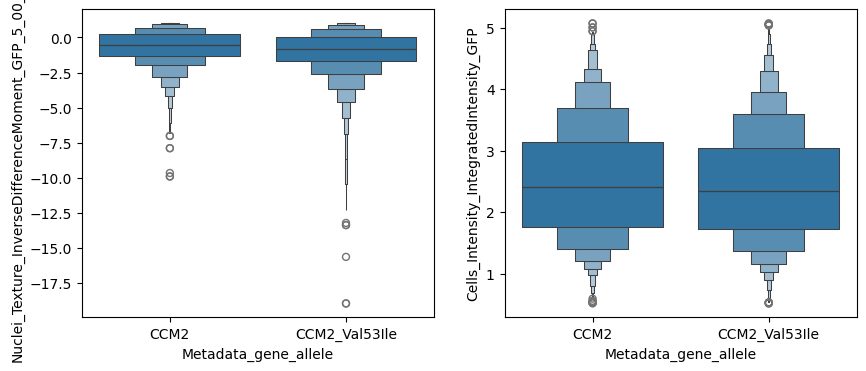

Generating separate figures for CCM2_Val53Ile with 50 cells each
['B19A8A10R1_P2' 'B19A8A10R1_P2']
Var len: 84 Ref len: 73


<Figure size 640x480 with 0 Axes>

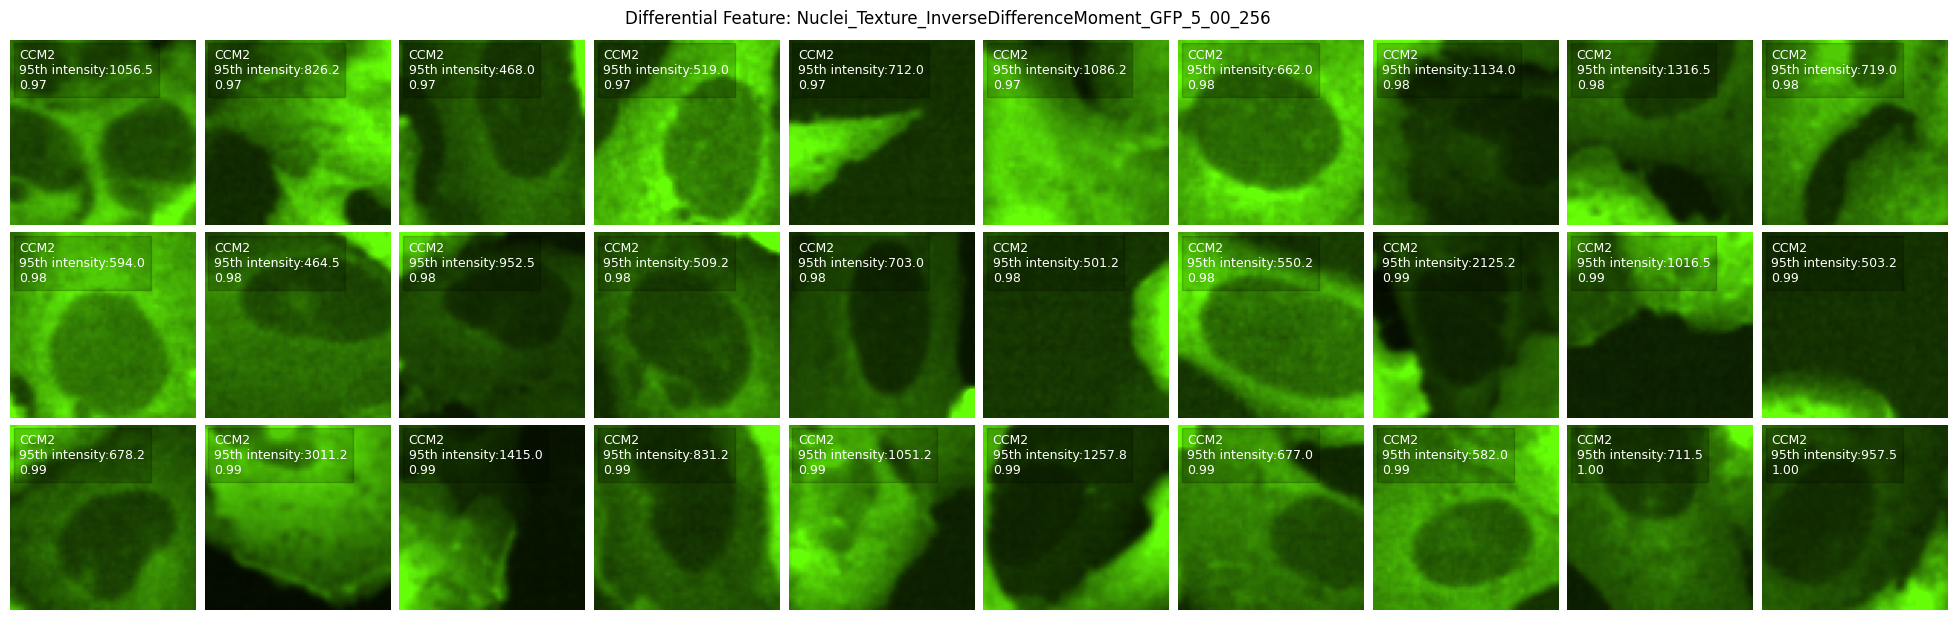

<Figure size 640x480 with 0 Axes>

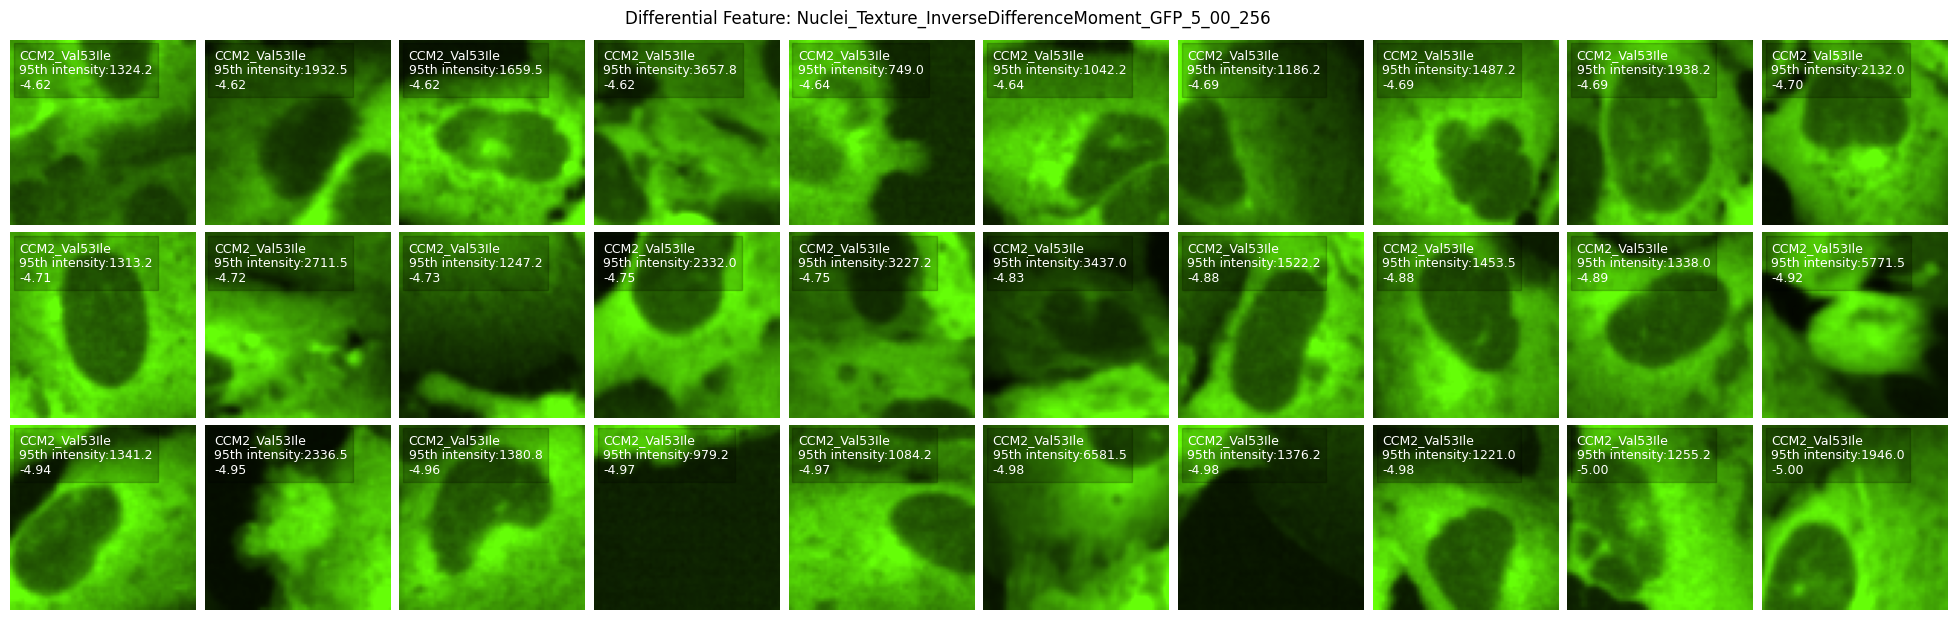

In [5]:
plot_var_key_feat_cell_crops("CCM2_Val53Ile", "Nuclei_Texture_InverseDifferenceMoment_GFP_5_00_256", auroc_df, sel_channel=["GFP"], compartment="Nuclei")

<Figure size 640x480 with 0 Axes>

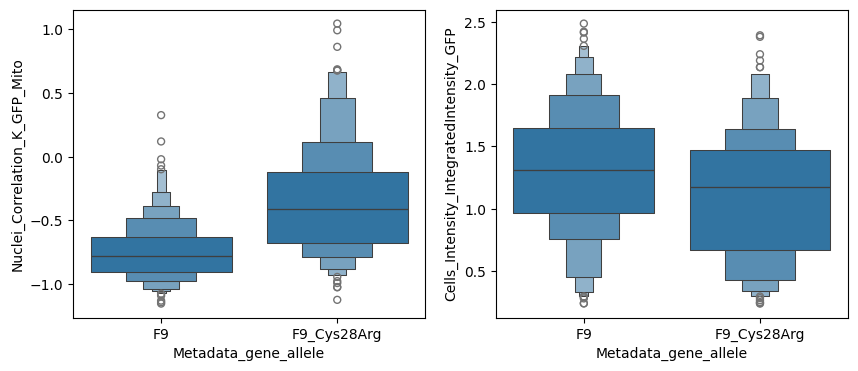

Generating separate figures for F9_Cys28Arg with 50 cells each
['B14A7A8P1_R2']


Var len: 191 Ref len: 200


<Figure size 640x480 with 0 Axes>

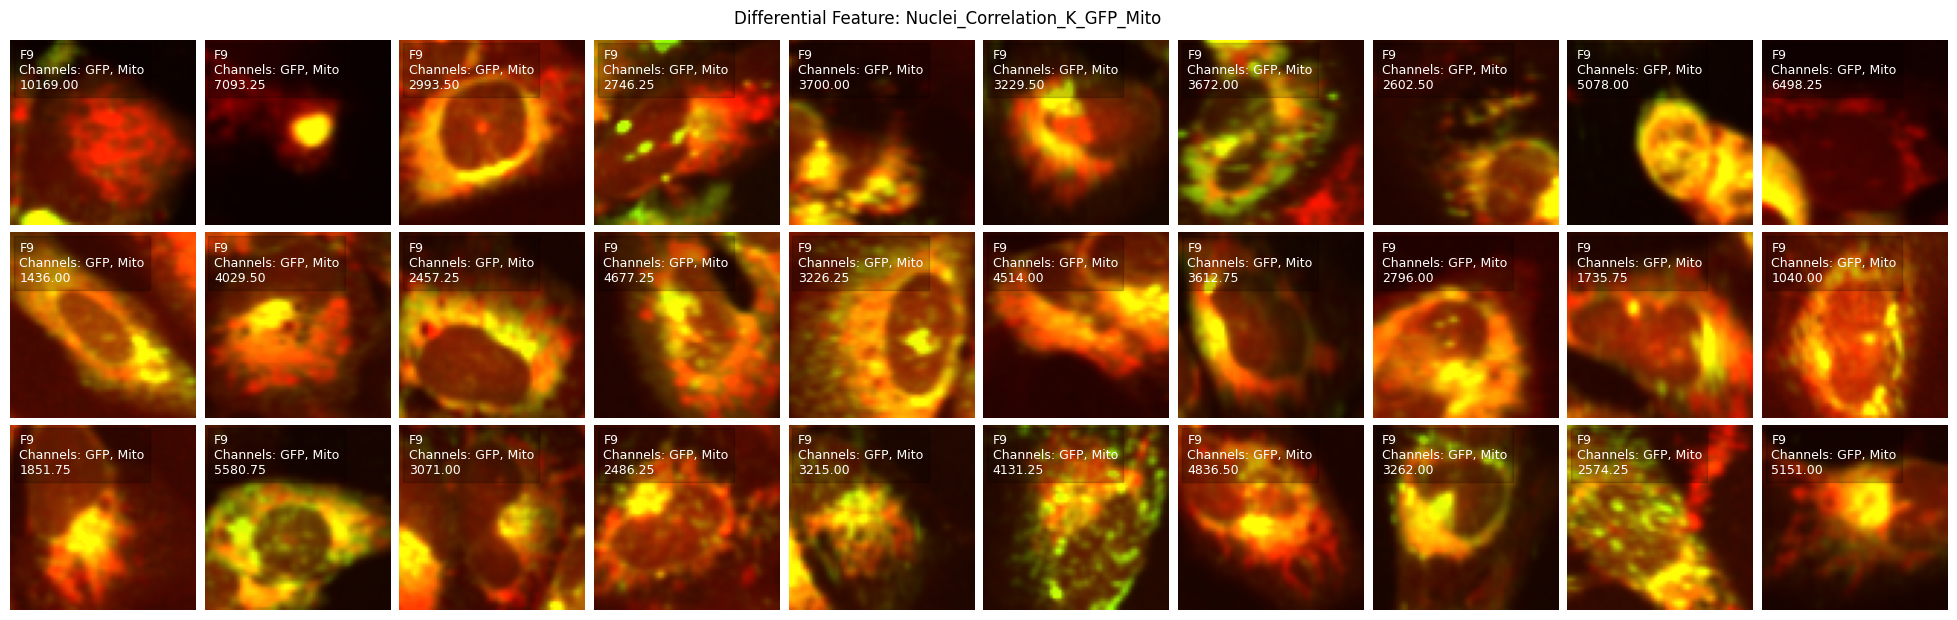

<Figure size 640x480 with 0 Axes>

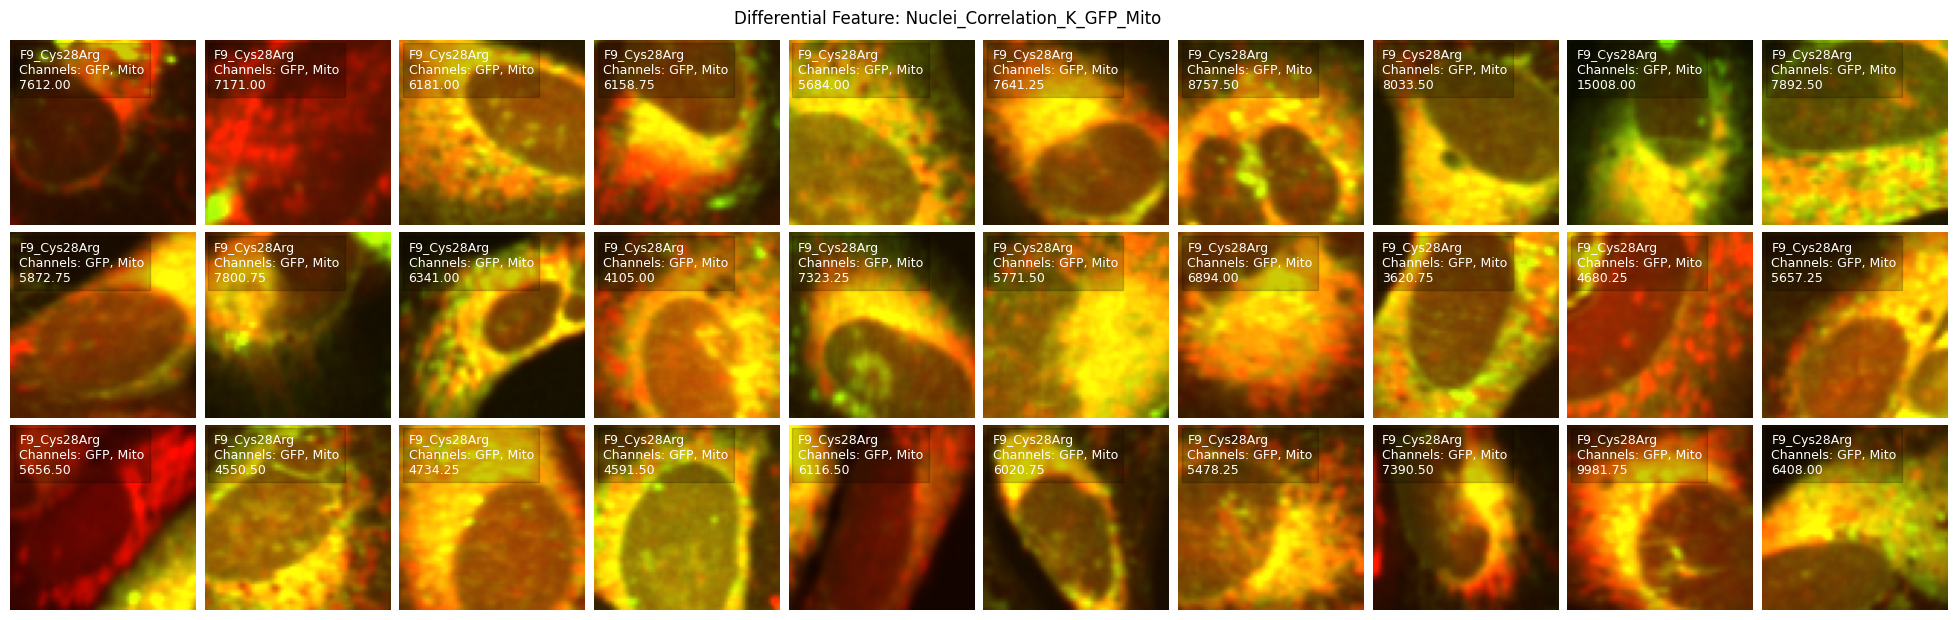

In [6]:
plot_var_key_feat_cell_crops("F9_Cys28Arg", "Nuclei_Correlation_K_GFP_Mito", auroc_df, sel_channel=["GFP", "Mito"], compartment="Nuclei")

In [ ]:
# plot_var_key_feat_cell_crops("F9_Cys28Arg", "Nuclei_Correlation_K_GFP_Mito")
# plot_var_key_feat_cell_crops("F9_Cys28Arg", "Nuclei_Correlation_K_GFP_Mito", ["Mito"])
# plot_var_key_feat_cell_crops("F9_Cys28Arg", "Cytoplasm_Correlation_RWC_DNA_GFP")

<Figure size 640x480 with 0 Axes>

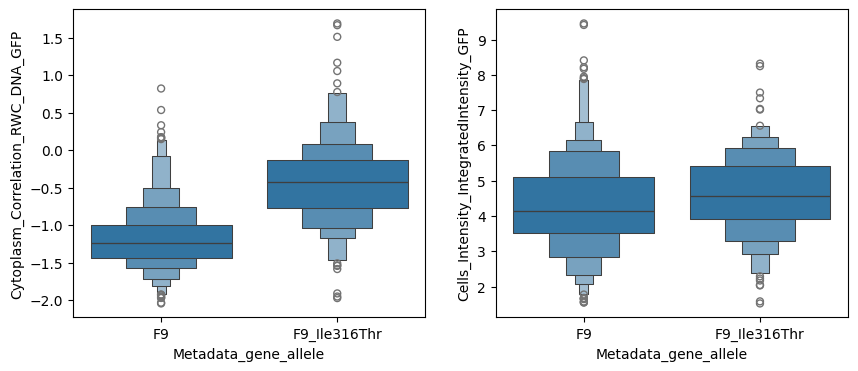

Generating separate figures for F9_Ile316Thr with 50 cells each
['B14A7A8P1_R2']
Var len: 200 Ref len: 200


<Figure size 640x480 with 0 Axes>

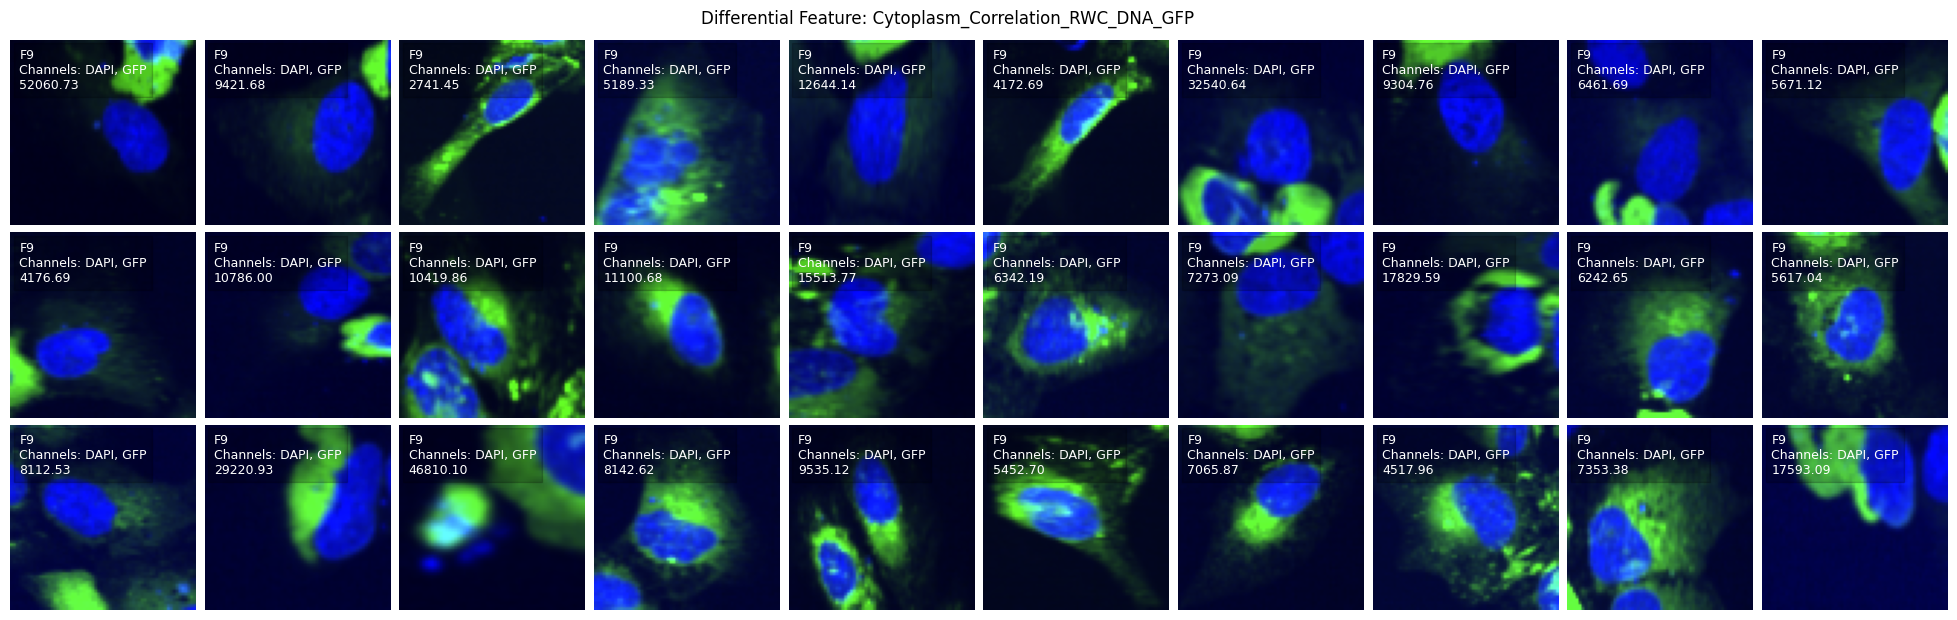

<Figure size 640x480 with 0 Axes>

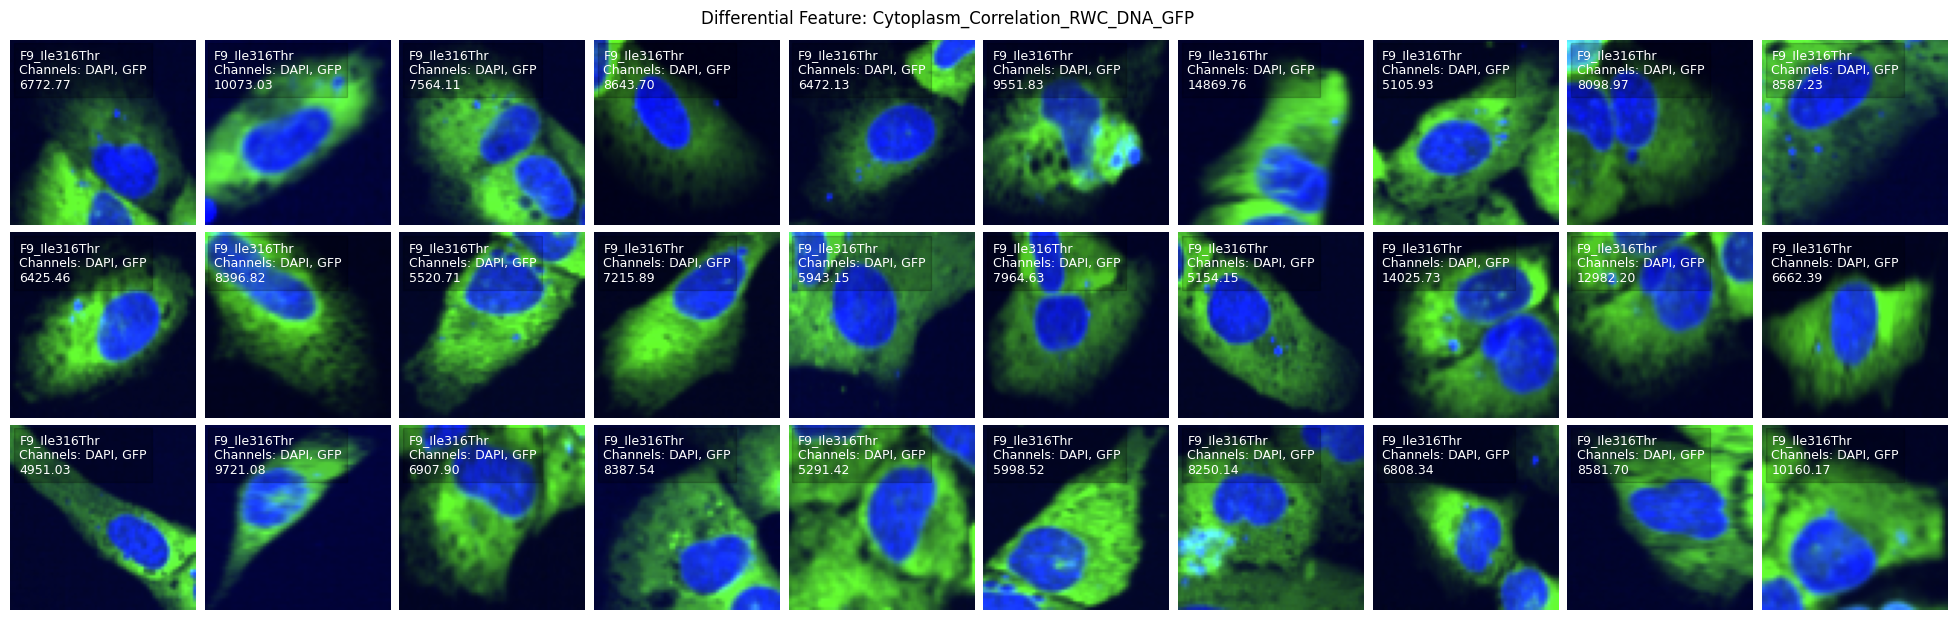

In [5]:
plot_var_key_feat_cell_crops("F9_Ile316Thr", "Cytoplasm_Correlation_RWC_DNA_GFP", auroc_df, sel_channel=["DAPI", "GFP"], compartment="Cells", resize_fig=True)
# plot_var_key_feat_cell_crops("F9_Cys28Arg", "Cytoplasm_Correlation_RWC_DNA_GFP", "DAPI")
# plot_var_key_feat_cell_crops("F9_Ile316Thr", "Nuclei_Correlation_K_GFP_Mito")
# plot_var_key_feat_cell_crops("F9_Ile316Thr", "Cytoplasm_Correlation_RWC_DNA_GFP", "DAPI")

In [81]:
batch_profiles_filtered = {}
key_feat_sel = "Nuclei_Correlation_K_GFP_Mito"
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in BIO_REP_BATCHES_DICT[bio_rep]:
        imagecsv_dir = IMG_ANALYSIS_DIR.format(batch_id) #f"../../../8.1_upstream_analysis_runxi/2.raw_img_qc/inputs/images/{batch_id}/analysis"
        prof_path = BATCH_PROFILES.format(batch_id)
        # print(prof_path)
        # Get metadata
        profiles_filt = pl.scan_parquet(prof_path).select(
            ["Metadata_well_position", "Metadata_ImageNumber", "Metadata_ObjectNumber", "Metadata_Plate", "Metadata_refvar_gfp_adj_classify", key_feat_sel, "Cytoplasm_Correlation_RWC_DNA_GFP", GFP_INTENSITY_COLUMN
            # "Nuclei_AreaShape_Area", "Cells_AreaShape_Area", "Nuclei_AreaShape_Center_X", "Nuclei_AreaShape_Center_Y",
            # "Cells_AreaShape_BoundingBoxMaximum_X", "Cells_AreaShape_BoundingBoxMaximum_Y", "Cells_AreaShape_BoundingBoxMinimum_X",
            # "Cells_AreaShape_BoundingBoxMinimum_Y",	"Cells_AreaShape_Center_X",	"Cells_AreaShape_Center_Y",
            # "Cells_Intensity_MeanIntensity_GFP", "Cells_Intensity_MedianIntensity_GFP", "Cells_Intensity_IntegratedIntensity_GFP"
            ],
        ).collect()
    
        # Sort by allele, then image number
        profiles_filt = profiles_filt.with_columns(
            # pl.concat_str(["Metadata_Plate", "Metadata_well_position", "Metadata_Site"], separator="_").alias("Metadata_SiteID"),
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_well_position",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID"),
        ).select(["Metadata_CellID", "Metadata_refvar_gfp_adj_classify", key_feat_sel, "Cytoplasm_Correlation_RWC_DNA_GFP", GFP_INTENSITY_COLUMN]).join(
            batch_profiles[batch_id], on="Metadata_CellID", how="inner"
        )
        # profiles = profiles.sort(["Protein_label", "Metadata_SiteID"])
        # alleles = profiles.select("Protein_label").to_series().unique().to_list()
        batch_profiles_filtered[batch_id] = profiles_filt

select_cell_ids_df = pl.DataFrame()
variants_list = ['F9_Asn166Tyr', 'F9_Cys335Tyr', 'F9_Cys335Trp', 'F9_Arg294Gln',
       'F9_Ile316Thr', 'F9_Trp453Arg', 'F9_Cys28Arg', 'F9_Pro333Leu']
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in BIO_REP_BATCHES_DICT[bio_rep]:
        select_cell_ids_df = pl.concat([
            select_cell_ids_df,
            batch_profiles_filtered[batch_id].filter(
                pl.col("Metadata_refvar_gfp_adj_classify").str.extract_all(r'|'.join(variants_list)).list.len() > 0
                # (pl.col("Cells_AreaShape_Area") < 7000) & (pl.col("Cells_AreaShape_Area") > 5000),
            ).sort("Metadata_gene_allele")
        ])

In [1]:
# from scipy.stats import spearmanr
# ax = sns.regplot(
#     data=select_cell_ids_df.to_pandas(),
#     x=key_feat_sel,
#     y=GFP_INTENSITY_COLUMN,
#     ci=False,
#     fit_reg=False
# )
# # ax.set_xlim(None, 0.5)

# rho, p_val = spearmanr(
#     select_cell_ids_df.to_pandas()[key_feat_sel], 
#     select_cell_ids_df.to_pandas()[GFP_INTENSITY_COLUMN]
# )
# print(rho, p_val)
# plt.show()

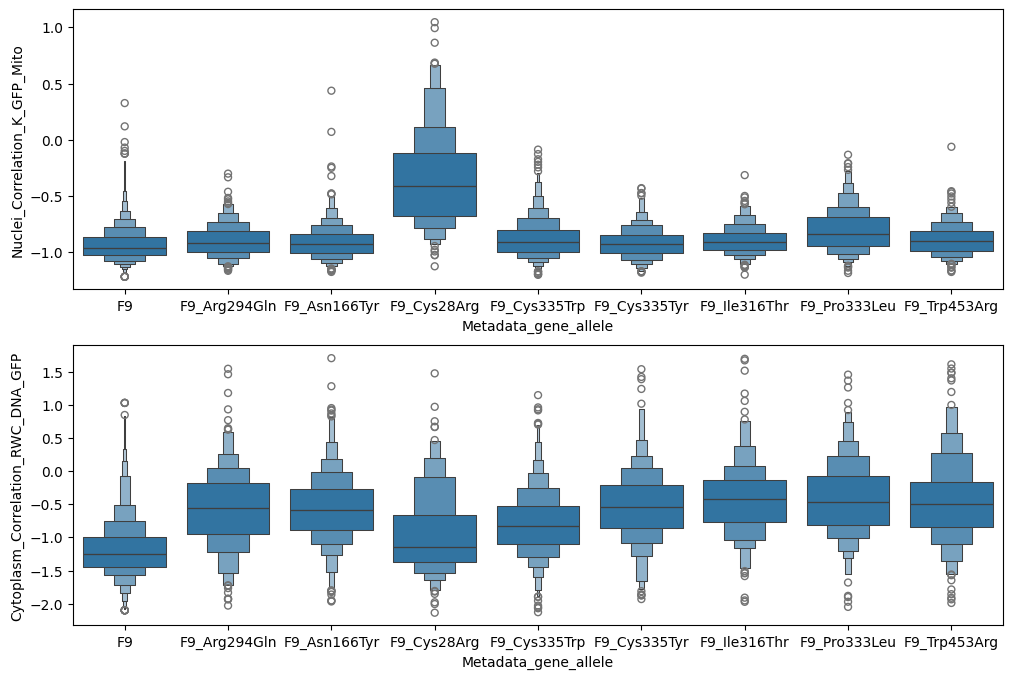

In [85]:
fig, axes = plt.subplots(2,1,figsize=(12,8))
ax = sns.boxenplot(
    data=select_cell_ids_df.to_pandas(),
    x="Metadata_gene_allele",
    y=key_feat_sel,
    ax=axes[0]
)
sns.boxenplot(
    data=select_cell_ids_df.to_pandas(),
    x="Metadata_gene_allele",
    y="Cytoplasm_Correlation_RWC_DNA_GFP",
    ax=axes[1]
)
plt.show()

In [27]:
# save_allele_cell_imgs("FOXP3_Leu242Pro", feat="GFP", batch_profile_dict=batch_profiles, display=True)
# save_allele_cell_imgs("TPM1_Asn279His", feat="GFP", batch_profile_dict=batch_profiles, display=True)
# save_allele_cell_imgs("RAD51D_Glu233Gly", feat="GFP", batch_profile_dict=batch_profiles, display=True)
# save_allele_cell_imgs("RAD51D_Val28Leu", feat="GFP", batch_profile_dict=batch_profiles, display=True)

# for variant in tqdm(allele_list): ## ["F9_Ile316Thr"]
#     for feat in ["AGP","Mito","GFP"]:
#         save_allele_cell_imgs(variant, feat=feat, batch_profile_dict=batch_profiles, display=False, save_img=True)

# plot_allele_cell_multi(allele_meta_df_dict["2025_01_Batch_13-14"], variant, 
#                  sel_channel=["AGP","Mito","GFP"], 
#                  plate_img_qc=img_well_qc_sum_dict["2025_01_Batch_13-14"],
#                  auroc_df=None, batch_profile_dict=batch_profiles, display=True, 
#                  # output_dir=f"{OUT_CELL_DIR}/2025_01_Batch_13-14"
# )

In [2]:
# save_allele_cell_imgs("RAD51D_Val28Leu", feat="GFP", batch_profile_dict=batch_profiles, display=True)

## 3. Multi-channel overlay

In [58]:
# save_allele_cell_imgs("MVK_Ser329Asn", feat="GFP", batch_profile_dict=batch_profiles, display=True)

In [57]:
# save_allele_cell_imgs("MLH1_Ile36Asn", feat="GFP", batch_profile_dict=batch_profiles, display=True)

In [ ]:
# rsync -avz username@server_ip:/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/visualize_imgs/2025_01_Batch_13-14/F9*.png /local/destination/path/